# Use pytorch to predict Log TPM data, keep BLAST connected components in same split
A relatively simple task: determine from the promoter if the gene should be generally highly or generally lowly expressed. If we can't do this, then we should not expect the model to do anything more complicated. 

At one point, we realized that many promoters share very high sequence similarity with others, some of which have higly correlated expression. To prevent the model from having train/val leakage, we implement a split to keep promoters in the same BLAST connected component in the same train/val/test split

In [1]:
import torch
from torch import nn

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score

import models as m
import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [3]:
from skorch import NeuralNetRegressor


In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    #os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


## Load 5G logTPM data

In [5]:
cond_file = 'data/conditions_to_include_20221031.txt'
with open(cond_file, 'r') as f:
    conds = [x.strip() for x in f.readlines()]
    
conds

['uMax',
 'lowO2_fast_growth',
 'lowCH4',
 'MeOH',
 'NoCu',
 'medCu',
 'highCu',
 'lowCu',
 'highO2_slow_growth',
 'NO3_lowO2_slow_growth',
 'WithLanthanum',
 'NoLanthanum',
 'LanzaTech',
 'aa3_KO',
 'crotonic_acid',
 'CH4_500ppm',
 'CH4_1000ppm']

In [6]:
sample_file = 'data/sample2condition_20221031.txt'
with open(sample_file, 'r') as f:
    samp2cond = dict([x.strip().split('\t') for x in f.readlines()])
    
samp2cond.keys()

dict_keys(['5GB1_ferm_Ack_QC_tpm', '5GB1_ferm_WT_QC_tpm', '5GB1_FM03_TR1_QC_tpm', '5GB1_FM03_TR2_QC_tpm', '5GB1_FM11_TR1_QC_tpm', '5GB1_FM11_TR2_QC_tpm', '5GB1_FM12_TR1_tpm', '5GB1_FM12_TR1_QC_tpm', '5GB1_FM12_TR2_tpm', '5GB1_FM12_TR2_QC_tpm', '5GB1_FM14_TR1_tpm', '5GB1_FM14_TR1_QC_tpm', '5GB1_FM14_TR2_tpm', '5GB1_FM14_TR2_QC_tpm', '5GB1_FM18_TR1_QC_tpm', '5GB1_FM18_TR2_tpm', '5GB1_FM18_TR2_QC_tpm', '5GB1_FM18_TR3_tpm', '5GB1_FM18_TR3_QC_tpm', '5GB1_FM19_TR1_tpm', '5GB1_FM19_TR1_QC_tpm', '5GB1_FM19_TR1_UW_tpm', '5GB1_FM19_TR3_tpm', '5GB1_FM19_TR3_QC_tpm', '5GB1_FM20_TR1_QC_tpm', '5GB1_FM20_TR2_QC_tpm', '5GB1_FM20_TR3_tpm', '5GB1_FM20_TR3_QC_tpm', '5GB1_FM20_TR3_UW_tpm', '5GB1_FM21_TR1_tpm', '5GB1_FM21_TR1_QC_tpm', '5GB1_FM21_TR2_tpm', '5GB1_FM21_TR2_QC_tpm', '5GB1_FM21_TR2_UW_tpm', '5GB1_FM22_TR1_tpm', '5GB1_FM22_TR1_QC_tpm', '5GB1_FM22_TR3_tpm', '5GB1_FM22_TR3_QC_tpm', '5GB1_FM22_TR3_UW_tpm', '5GB1_FM23_TR3_tpm', '5GB1_FM23_TR3_QC_tpm', '5GB1_FM34_T0_TR1_QC_tpm', '5GB1_FM34_T3_TR3_QC_

In [7]:
samples = [x for x in samp2cond if samp2cond[x] in conds]
print(len(samples))
print(len(samp2cond))

# samples does not include a sample who's cond is not in conds

90
102


In [8]:
#locus_info_filename = 'data/locus2info.tsv'
locus_info_filename = 'data/locus2info_20221031.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t').fillna("")
display(locus_info_df.head())
locus2info = u.make_info_dict(locus_info_df)

tpm_data_filename = "data/5GB1_tpms_20221031.tsv"
tpm_df = pd.read_csv(tpm_data_filename,sep='\t').fillna("")

display(tpm_df.head())

print(locus2info['EQU24_RS23150'])
display(tpm_df[tpm_df['locus_tag']=='EQU24_RS23150'])

,locus_tag,gene_symbol,product,type
0,EQU24_RS00005,dnaA,chromosomal replication initiator protein DnaA,CDS
1,EQU24_RS00010,dnaN,DNA polymerase III subunit beta,CDS
2,EQU24_RS00015,recF,DNA replication/repair protein RecF,CDS
3,EQU24_RS00020,gyrB,DNA topoisomerase (ATP-hydrolyzing) subunit B,CDS
4,EQU24_RS00035,,hypothetical protein,CDS


,locus_tag,product,type,gene_symbol,locus,start_coord,end_coord,note,gene_len,5GB1_ferm_Ack_QC_tpm,...,5GB1C-5G-N-BR1_tpm,5GB1C-5G-N-BR2_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm,5GB1C_CH4_500ppm-Rep1_tpm,5GB1C_CH4_500ppm-Rep2_tpm,5GB1C_CH4_1000ppm-Rep2_tpm,5GB1C_CH4_1000ppm-Rep1_tpm
0,EQU24_RS00005,chromosomal replication initiator protein DnaA,CDS,dnaA,NZ_CP035467.1,0,1317,Derived by automated computational analysis us...,1318,2.920380,...,38.638102,31.867873,30.546267,36.840627,29.198516,35.405768,56.747208,55.734395,46.812595,35.325741
1,EQU24_RS00010,DNA polymerase III subunit beta,CDS,dnaN,NZ_CP035467.1,1502,2603,Derived by automated computational analysis us...,1102,1.600865,...,45.092244,45.889651,34.824076,44.661748,35.864388,45.409001,32.721559,33.467532,34.906928,30.020538
2,EQU24_RS00015,DNA replication/repair protein RecF,CDS,recF,NZ_CP035467.1,3060,4140,Derived by automated computational analysis us...,1081,1.409423,...,21.362765,20.976809,17.355043,21.854708,18.734014,25.608242,26.409599,23.529439,21.368579,16.896055
3,EQU24_RS00020,DNA topoisomerase (ATP-hydrolyzing) subunit B,CDS,gyrB,NZ_CP035467.1,4185,6600,Derived by automated computational analysis us...,2416,3.186309,...,57.478160,61.623220,52.941842,63.050677,55.592843,58.631387,48.167231,51.249206,61.811500,54.226180
4,EQU24_RS00035,hypothetical protein,CDS,,NZ_CP035467.1,7350,7734,Derived by automated computational analysis us...,385,8.852007,...,118.910610,106.287739,102.200487,116.972791,105.924563,129.975893,86.942252,83.059104,118.967455,94.451247


{'gene': 'hxlB', 'product': '6-phospho-3-hexuloisomerase', 'type': 'CDS'}


,locus_tag,product,type,gene_symbol,locus,start_coord,end_coord,note,gene_len,5GB1_ferm_Ack_QC_tpm,...,5GB1C-5G-N-BR1_tpm,5GB1C-5G-N-BR2_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm,5GB1C_CH4_500ppm-Rep1_tpm,5GB1C_CH4_500ppm-Rep2_tpm,5GB1C_CH4_1000ppm-Rep2_tpm,5GB1C_CH4_1000ppm-Rep1_tpm
4183,EQU24_RS23150,6-phospho-3-hexuloisomerase,CDS,hxlB,NZ_CP035467.1,4877125,4877659,Derived by automated computational analysis us...,535,39.344956,...,2365.689931,2769.139632,1243.677654,1770.553275,2378.489135,2178.110269,1520.59018,1588.76192,2084.454046,1961.803703


In [9]:
log_tpm_df = pd.read_csv("data/XY_logTPM_opFilt_20221031.tsv",sep='\t')
log_tpm_df

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.478624,5.057673,4.896853,4.490890,5.145182,5.397970,5.405936,5.192777,5.969066,4.930030,5.027548,4.964473,4.628472,4.672580,5.203285,5.813802,5.360335
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.690592,5.327593,5.018030,4.187744,5.511274,5.929589,6.122296,5.687118,6.581135,5.375959,5.266481,5.349840,5.748453,5.432198,5.643963,5.048957,5.021201
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,4.863056,4.668366,4.159345,4.151060,4.498207,4.786031,4.885784,4.585745,5.439145,4.344218,4.249195,4.431874,3.510871,3.507901,4.979830,4.642674,4.258694
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,6.236072,6.078456,6.178559,5.400475,6.042533,6.231928,6.387618,6.075307,6.562648,5.781786,6.685816,6.608930,5.090150,5.577019,6.052065,6.409572,6.737678
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.553060,4.663626,3.639238,3.367896,4.379804,4.595742,4.686595,4.444783,4.238753,4.453061,4.918992,5.002460,3.663770,4.354762,4.450588,4.012562,4.059889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.237420,11.335500,10.863092,9.018391,10.617199,10.788779,11.118496,10.625349,10.234527,12.057299,11.594911,12.181570,11.319127,12.194560,11.395111,11.080633,11.344901
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.240275,11.332696,10.861885,9.015633,10.630280,10.784309,11.113859,10.624571,10.255792,12.052196,11.583235,12.178662,11.331736,12.203430,11.391490,11.064205,11.335484
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,11.245186,11.327803,10.873490,9.044817,10.639739,10.811677,11.125770,10.655103,10.317302,12.046530,11.539422,12.082225,11.348469,12.160149,11.409383,10.671998,10.945555
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,5.687342,5.279725,4.821525,5.208461,5.082854,5.068202,5.311955,4.899572,5.240644,4.812318,4.849694,5.189988,5.348046,4.212482,5.896935,4.837302,4.797353


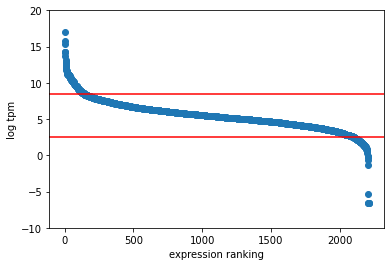

In [10]:
hicu = sorted(log_tpm_df['highCu'].values, reverse=True)

x,y = list(zip(*enumerate(hicu)))
plt.scatter(x,y)
#plt.yscale('log')
plt.ylim(-10,20)
plt.axhline(8.5,c='red')
plt.axhline(2.5,c='red')
plt.xlabel('expression ranking')
plt.ylabel('log tpm')
plt.show()

In [11]:
uppert = 8.5
lowert = 2.5

hi_hicu = log_tpm_df[log_tpm_df['highCu']>uppert]
med_hicu = log_tpm_df[log_tpm_df['highCu'].between(lowert, uppert)]
low_hicu = log_tpm_df[log_tpm_df['highCu']<lowert]

In [12]:
print(hi_hicu.shape)
print(med_hicu.shape)
print(low_hicu.shape)

(143, 20)
(1959, 20)
(109, 20)


In [13]:
# calculate the mean across all samples, and the log of that number
tpm_df['overall_mean_tpm'] = tpm_df.apply(lambda row: np.mean(row[samples]) ,axis=1)
tpm_df['log_overall_mean_tpm'] = tpm_df['overall_mean_tpm'].apply(lambda x: np.log2(x))
tpm_df

,locus_tag,product,type,gene_symbol,locus,start_coord,end_coord,note,gene_len,5GB1_ferm_Ack_QC_tpm,...,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm,5GB1C_CH4_500ppm-Rep1_tpm,5GB1C_CH4_500ppm-Rep2_tpm,5GB1C_CH4_1000ppm-Rep2_tpm,5GB1C_CH4_1000ppm-Rep1_tpm,overall_mean_tpm,log_overall_mean_tpm
0,EQU24_RS00005,chromosomal replication initiator protein DnaA,CDS,dnaA,NZ_CP035467.1,0,1317,Derived by automated computational analysis us...,1318,2.920380,...,30.546267,36.840627,29.198516,35.405768,56.747208,55.734395,46.812595,35.325741,36.622138,5.194644
1,EQU24_RS00010,DNA polymerase III subunit beta,CDS,dnaN,NZ_CP035467.1,1502,2603,Derived by automated computational analysis us...,1102,1.600865,...,34.824076,44.661748,35.864388,45.409001,32.721559,33.467532,34.906928,30.020538,46.466629,5.538123
2,EQU24_RS00015,DNA replication/repair protein RecF,CDS,recF,NZ_CP035467.1,3060,4140,Derived by automated computational analysis us...,1081,1.409423,...,17.355043,21.854708,18.734014,25.608242,26.409599,23.529439,21.368579,16.896055,24.181343,4.595822
3,EQU24_RS00020,DNA topoisomerase (ATP-hydrolyzing) subunit B,CDS,gyrB,NZ_CP035467.1,4185,6600,Derived by automated computational analysis us...,2416,3.186309,...,52.941842,63.050677,55.592843,58.631387,48.167231,51.249206,61.811500,54.226180,52.516137,5.714689
4,EQU24_RS00035,hypothetical protein,CDS,,NZ_CP035467.1,7350,7734,Derived by automated computational analysis us...,385,8.852007,...,102.200487,116.972791,105.924563,129.975893,86.942252,83.059104,118.967455,94.451247,72.804010,6.185946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4184,EQU24_RS23155,3-hexulose-6-phosphate synthase,CDS,hxlA,NZ_CP035467.1,4877662,4878310,Derived by automated computational analysis us...,649,54.488824,...,2972.807778,3975.569016,4832.782004,5503.508261,2093.320771,2189.062660,2612.122268,2556.194919,2323.469042,11.182065
4185,EQU24_RS23160,6-phospho-3-hexuloisomerase,CDS,hxlB,NZ_CP035467.1,4882314,4882848,Derived by automated computational analysis us...,535,39.120128,...,1240.700959,1765.269056,2365.333503,2142.160596,1521.529928,1598.613630,2081.876627,1962.755769,1833.953899,10.840742
4186,EQU24_RS23165,3-hexulose-6-phosphate synthase,CDS,hxlA,NZ_CP035467.1,4882851,4883499,Derived by automated computational analysis us...,649,49.546527,...,2831.473500,3738.866442,4470.981143,5103.421732,1613.939517,1649.074688,2003.711339,1940.573398,2285.823809,11.158498
4187,EQU24_RS23170,transposase,CDS,,NZ_CP035467.1,4918898,4919603,Derived by automated computational analysis us...,706,5.792673,...,23.052263,30.934037,35.897452,41.177703,32.119364,25.035217,28.898838,26.694263,36.482158,5.189119


In [14]:
# # Spot check a few:
# pmoc_row = tpm_df[tpm_df['locus_tag']=='EQU24_RS19315']
# psamps = pmoc_row[samples].values
# np.mean(psamps)

In [15]:
# pmoc_row['overall_mean_tpm']

In [16]:
# # Use one of the other XY dfs to get the upstream regions
# XY_cond_df = pd.read_csv('data/XY_TPM_opFilt_20221031.tsv',sep='\t')
# display(XY_cond_df.head())
# loc2seq = dict([(x,z) for (x,z) in XY_cond_df[['locus_tag','upstream_region']].values])

# print(locus2info['EQU24_RS19315'])
# print(loc2seq['EQU24_RS19315'])

# print(locus2info['EQU24_RS23145'])
# print(loc2seq['EQU24_RS23145'])

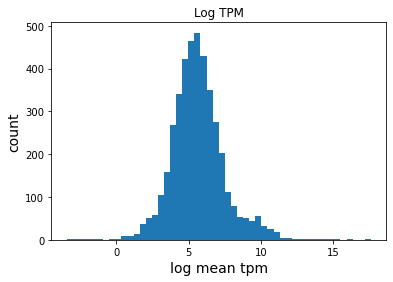

In [17]:
# Log TPM - mean log tpm column
plt.hist(tpm_df['log_overall_mean_tpm'].values,bins=50)
plt.xlabel("log mean tpm",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.title("Log TPM")
plt.show()

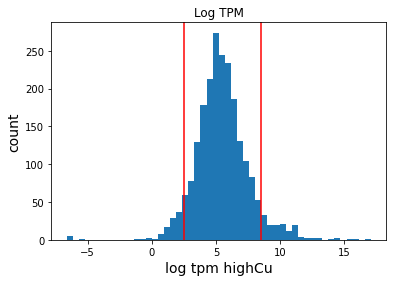

In [18]:
# Log TPM - highCu log tpm column
plt.hist(log_tpm_df['highCu'].values,bins=50)
plt.xlabel("log tpm highCu",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.axvline(uppert,c='red')
plt.axvline(lowert,c='red')
plt.title("Log TPM")
plt.show()

In [19]:
# assemble xy df
# XY_df = XY_cond_df[['locus_tag','upstream_region']]
# XY_df = pd.merge(XY_df,tpm_df[['locus_tag','log_overall_mean_tpm']],on='locus_tag',how='left')
# XY_df

In [20]:
# Log TPM - mean log tpm column - Op Filt
# plt.hist(XY_df['log_overall_mean_tpm'].values,bins=50)
# plt.xlabel("log mean tpm",fontsize=14)
# plt.ylabel("count",fontsize=14)
# plt.title("Log TPM")
# plt.show()

### *This is the distribution I'm trying to predict*

## Add Null Seq Column

In [21]:
def shuffle_seq(dna):
    to_shuffle = list(dna)
    random.shuffle(to_shuffle)
    return  ''.join(to_shuffle)

log_tpm_df['shuffled_seq'] = log_tpm_df['upstream_region'].apply(lambda x: shuffle_seq(x))
log_tpm_df[['upstream_region','shuffled_seq']]

,upstream_region,shuffled_seq
0,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,GTCTTCTGAGTGTTATAAGCTGGAGTTCTTCAGTGTTGTGTACCCA...
1,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,TTGATGTGTATATTGGACCTAACTACGCAAACCTTTGTCCTTGTAA...
2,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,TAGGCAGACTTGGTAAGGTTCGTATTAGATGTCAAAGTAAGAGGTA...
3,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,ACCATGCTAGACCATTCTCTAAAGCACATCTAGAGGTTACTTGTTA...
4,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,ATTTATGAAGATACTACTACGCCAACACGCCTTTTCTGCTCGAATG...
...,...,...
2206,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,CAAAATGTCAATCTGGTGTCTGAAAACGGCGCATCCAAAGATCGCT...
2207,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,GTCTCCATAGAAACGCCATGGCATGAAATTCAAGTTTCTGTCGACG...
2208,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,AGCTTGAAATTGGACTCTAGTCTTCGTCATTTTTGATGACACTTAG...
2209,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,GTTAGAGGTGAAGTAACAACTTCCGTTGAGCGTGTTGGTTTTAGAA...


## Modified Train/test split

In [22]:
from sklearn.model_selection import GroupKFold,GroupShuffleSplit

In [23]:
# load connected component map
loc2cc = dict(pd.read_csv('data/loc2ccid_aln200_pident90.tsv',sep='\t').values)
loc2cc

{'EQU24_RS00080': 0,
 'EQU24_RS00085': 0,
 'EQU24_RS00165': 1,
 'EQU24_RS00175': 2,
 'EQU24_RS00180': 2,
 'EQU24_RS00210': 3,
 'EQU24_RS00225': 4,
 'EQU24_RS00230': 4,
 'EQU24_RS00245': 5,
 'EQU24_RS00250': 5,
 'EQU24_RS00255': 6,
 'EQU24_RS00260': 6,
 'EQU24_RS00275': 7,
 'EQU24_RS00625': 8,
 'EQU24_RS00640': 9,
 'EQU24_RS00645': 10,
 'EQU24_RS00650': 11,
 'EQU24_RS00690': 12,
 'EQU24_RS00695': 12,
 'EQU24_RS00845': 13,
 'EQU24_RS00850': 13,
 'EQU24_RS00860': 14,
 'EQU24_RS00865': 14,
 'EQU24_RS00930': 11,
 'EQU24_RS01010': 15,
 'EQU24_RS01015': 15,
 'EQU24_RS01030': 1,
 'EQU24_RS01060': 16,
 'EQU24_RS01125': 17,
 'EQU24_RS01255': 18,
 'EQU24_RS01260': 18,
 'EQU24_RS01385': 19,
 'EQU24_RS01390': 20,
 'EQU24_RS01395': 20,
 'EQU24_RS01425': 21,
 'EQU24_RS01430': 21,
 'EQU24_RS01475': 22,
 'EQU24_RS01480': 22,
 'EQU24_RS01550': 23,
 'EQU24_RS01560': 23,
 'EQU24_RS01630': 24,
 'EQU24_RS01635': 24,
 'EQU24_RS01795': 25,
 'EQU24_RS01810': 26,
 'EQU24_RS01815': 27,
 'EQU24_RS01820': 27,
 'EQ

In [24]:
max(loc2cc.values())

177

In [25]:
def get_ccid(locus):
    '''
    If the locus is not yet in the cc dict, give it the 
    id of +1 of the max value in the dict. Add it to 
    the dict so the next id increments.
    '''
    new_id = max(loc2cc.values())+1
    if locus in loc2cc:
        return loc2cc[locus]
    else:
        loc2cc[locus] = new_id
        return new_id

In [26]:
log_tpm_df['cc_id'] = log_tpm_df['locus_tag'].apply(lambda x: get_ccid(x))
log_tpm_df

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,shuffled_seq,cc_id
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.478624,5.057673,4.896853,4.490890,5.145182,5.397970,5.405936,...,4.930030,5.027548,4.964473,4.628472,4.672580,5.203285,5.813802,5.360335,GTCTTCTGAGTGTTATAAGCTGGAGTTCTTCAGTGTTGTGTACCCA...,178
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.690592,5.327593,5.018030,4.187744,5.511274,5.929589,6.122296,...,5.375959,5.266481,5.349840,5.748453,5.432198,5.643963,5.048957,5.021201,TTGATGTGTATATTGGACCTAACTACGCAAACCTTTGTCCTTGTAA...,179
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,4.863056,4.668366,4.159345,4.151060,4.498207,4.786031,4.885784,...,4.344218,4.249195,4.431874,3.510871,3.507901,4.979830,4.642674,4.258694,TAGGCAGACTTGGTAAGGTTCGTATTAGATGTCAAAGTAAGAGGTA...,180
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,6.236072,6.078456,6.178559,5.400475,6.042533,6.231928,6.387618,...,5.781786,6.685816,6.608930,5.090150,5.577019,6.052065,6.409572,6.737678,ACCATGCTAGACCATTCTCTAAAGCACATCTAGAGGTTACTTGTTA...,181
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.553060,4.663626,3.639238,3.367896,4.379804,4.595742,4.686595,...,4.453061,4.918992,5.002460,3.663770,4.354762,4.450588,4.012562,4.059889,ATTTATGAAGATACTACTACGCCAACACGCCTTTTCTGCTCGAATG...,182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.237420,11.335500,10.863092,9.018391,10.617199,10.788779,11.118496,...,12.057299,11.594911,12.181570,11.319127,12.194560,11.395111,11.080633,11.344901,CAAAATGTCAATCTGGTGTCTGAAAACGGCGCATCCAAAGATCGCT...,177
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.240275,11.332696,10.861885,9.015633,10.630280,10.784309,11.113859,...,12.052196,11.583235,12.178662,11.331736,12.203430,11.391490,11.064205,11.335484,GTCTCCATAGAAACGCCATGGCATGAAATTCAAGTTTCTGTCGACG...,177
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,11.245186,11.327803,10.873490,9.044817,10.639739,10.811677,11.125770,...,12.046530,11.539422,12.082225,11.348469,12.160149,11.409383,10.671998,10.945555,AGCTTGAAATTGGACTCTAGTCTTCGTCATTTTTGATGACACTTAG...,171
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,5.687342,5.279725,4.821525,5.208461,5.082854,5.068202,5.311955,...,4.812318,4.849694,5.189988,5.348046,4.212482,5.896935,4.837302,4.797353,GTTAGAGGTGAAGTAACAACTTCCGTTGAGCGTGTTGGTTTTAGAA...,1962


In [28]:
def group_conscious_train_test_split(df,group_col,split_frac=0.8,make_plot=False):
    '''
    given a dataframe of examples with a column containing a group id, 
    split the df into train and test but make sure all examples
    of the same group id end up in the same split.
    '''
    df = df.reset_index()
    
    gss = GroupShuffleSplit(n_splits=1, train_size=.8, random_state=42)
    groups = df[group_col].values
    
    train_idxs,test_idxs = next(gss.split(df,groups=groups))
    
    train_df = df.loc[train_idxs]
    test_df = df.loc[test_idxs]
    
    if make_plot:
        train_vc = train_df['cc_id'].value_counts().reset_index()
        test_vc = test_df['cc_id'].value_counts().reset_index()
        
        plt.figure(figsize=(15,5))
        plt.bar(train_vc['index'],train_vc['cc_id'],label="Train split")
        plt.bar(test_vc['index'],test_vc['cc_id'],label="Test split")
        plt.yscale('log')
        plt.xlabel("connected component id")
        plt.ylabel("count of genes in connected component")
        plt.legend()
        plt.show()
    
    return train_df, test_df
    

In [29]:
#full_train_df,test_df = ccid_conscious_train_test_split(log_tpm_df)

In [30]:
def plot_train_test_hist(train_df, test_df,val_df=None,score_col='score',bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df[score_col].values,bins=bins,label="train")
    plt.hist(test_df[score_col].values,bins=bins,label='test')
    if val_df is not None:
        plt.hist(val_df[score_col].values,bins=bins,label='val')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()

def view_train_test_dist(train_df,test_df,score_cols,title,val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,test_df,val_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(df, id_vars=['locus_tag','set'],value_vars=score_cols,var_name='cond',value_name='tpm_lr')
    
    sns.stripplot(data=df_melt,x='cond',y='tpm_lr',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()

In [49]:
# LOG
#full_train_df,test_df = tu.quick_split(XY_df)
full_train_df,test_df = tu.quick_split(log_tpm_df)
train_df, val_df = tu.quick_split(full_train_df)

# Group conscious split
# full_train_df,test_df = group_conscious_train_test_split(log_tpm_df,'cc_id',make_plot=True)
# train_df, val_df = group_conscious_train_test_split(full_train_df,'cc_id',make_plot=True)

print(full_train_df.shape)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)

assert(train_df.shape[0] + val_df.shape[0] == full_train_df.shape[0])

(1768, 23)
(443, 23)
(1414, 24)
(354, 24)


In [50]:
full_train_df

,index,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,...,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,shuffled_seq,cc_id
0,0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.478624,5.057673,4.896853,4.490890,5.145182,5.397970,...,4.930030,5.027548,4.964473,4.628472,4.672580,5.203285,5.813802,5.360335,GTCTTCTGAGTGTTATAAGCTGGAGTTCTTCAGTGTTGTGTACCCA...,178
1,1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.690592,5.327593,5.018030,4.187744,5.511274,5.929589,...,5.375959,5.266481,5.349840,5.748453,5.432198,5.643963,5.048957,5.021201,TTGATGTGTATATTGGACCTAACTACGCAAACCTTTGTCCTTGTAA...,179
3,3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,6.236072,6.078456,6.178559,5.400475,6.042533,6.231928,...,5.781786,6.685816,6.608930,5.090150,5.577019,6.052065,6.409572,6.737678,ACCATGCTAGACCATTCTCTAAAGCACATCTAGAGGTTACTTGTTA...,181
4,4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.553060,4.663626,3.639238,3.367896,4.379804,4.595742,...,4.453061,4.918992,5.002460,3.663770,4.354762,4.450588,4.012562,4.059889,ATTTATGAAGATACTACTACGCCAACACGCCTTTTCTGCTCGAATG...,182
5,5,12,EQU24_RS00080,CCCAGACTGAACGCAACAGGATCGATATTAGGATAAGTCAGCATTT...,3.504904,2.823659,2.764909,2.814877,2.993438,3.086606,...,2.818427,3.579352,3.410549,1.836262,2.201298,3.045767,3.336137,3.186492,CGCAGAATAACATCAGTGGGCAAACGCTGGGAATGACTTTTAAGGT...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2204,2204,4176,EQU24_RS23115,TTCAAATCTTGCTTTGAGTCAGTAAATAGTAAGGTACTTTTGTTAA...,4.717098,4.252907,4.267814,4.094392,3.770267,4.027408,...,4.910349,6.346008,5.956263,4.465986,3.641980,5.050035,5.532330,5.051171,TCTTTGGAGAAAATCGAGTACTCAAAGGTATACGCCTACACCATTG...,1961
2205,2205,4180,EQU24_RS23135,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.226906,11.331245,10.850522,9.004862,10.624878,10.784705,...,12.045208,11.600581,12.175018,11.311065,12.186044,11.384621,11.073760,11.344292,CGGTTCCGTCGCTACATAAACATATATATTCCCACGGAACACCGAC...,177
2206,2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.237420,11.335500,10.863092,9.018391,10.617199,10.788779,...,12.057299,11.594911,12.181570,11.319127,12.194560,11.395111,11.080633,11.344901,CAAAATGTCAATCTGGTGTCTGAAAACGGCGCATCCAAAGATCGCT...,177
2209,2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,5.687342,5.279725,4.821525,5.208461,5.082854,5.068202,...,4.812318,4.849694,5.189988,5.348046,4.212482,5.896935,4.837302,4.797353,GTTAGAGGTGAAGTAACAACTTCCGTTGAGCGTGTTGGTTTTAGAA...,1962


In [51]:
train_df

,level_0,index,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,...,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,shuffled_seq,cc_id
0,0,0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.478624,5.057673,4.896853,4.490890,5.145182,...,4.930030,5.027548,4.964473,4.628472,4.672580,5.203285,5.813802,5.360335,GTCTTCTGAGTGTTATAAGCTGGAGTTCTTCAGTGTTGTGTACCCA...,178
1,1,1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.690592,5.327593,5.018030,4.187744,5.511274,...,5.375959,5.266481,5.349840,5.748453,5.432198,5.643963,5.048957,5.021201,TTGATGTGTATATTGGACCTAACTACGCAAACCTTTGTCCTTGTAA...,179
2,3,3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,6.236072,6.078456,6.178559,5.400475,6.042533,...,5.781786,6.685816,6.608930,5.090150,5.577019,6.052065,6.409572,6.737678,ACCATGCTAGACCATTCTCTAAAGCACATCTAGAGGTTACTTGTTA...,181
3,4,4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.553060,4.663626,3.639238,3.367896,4.379804,...,4.453061,4.918992,5.002460,3.663770,4.354762,4.450588,4.012562,4.059889,ATTTATGAAGATACTACTACGCCAACACGCCTTTTCTGCTCGAATG...,182
4,5,5,12,EQU24_RS00080,CCCAGACTGAACGCAACAGGATCGATATTAGGATAAGTCAGCATTT...,3.504904,2.823659,2.764909,2.814877,2.993438,...,2.818427,3.579352,3.410549,1.836262,2.201298,3.045767,3.336137,3.186492,CGCAGAATAACATCAGTGGGCAAACGCTGGGAATGACTTTTAAGGT...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761,2202,2202,4174,EQU24_RS23105,CGCTGCCGAAATTTGAAGTGCGAAAGGTATAGCTTCCGGGGGTTAT...,6.609598,6.321560,6.468997,5.390427,6.804992,...,7.340349,7.335241,7.572488,7.296559,7.391914,7.265471,7.059340,7.354961,GCTACGTGTCGGTGGGGTACATGCATCGAGTTCCGTATGTGAACAA...,1959
1764,2205,2205,4180,EQU24_RS23135,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.226906,11.331245,10.850522,9.004862,10.624878,...,12.045208,11.600581,12.175018,11.311065,12.186044,11.384621,11.073760,11.344292,CGGTTCCGTCGCTACATAAACATATATATTCCCACGGAACACCGAC...,177
1765,2206,2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.237420,11.335500,10.863092,9.018391,10.617199,...,12.057299,11.594911,12.181570,11.319127,12.194560,11.395111,11.080633,11.344901,CAAAATGTCAATCTGGTGTCTGAAAACGGCGCATCCAAAGATCGCT...,177
1766,2209,2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,5.687342,5.279725,4.821525,5.208461,5.082854,...,4.812318,4.849694,5.189988,5.348046,4.212482,5.896935,4.837302,4.797353,GTTAGAGGTGAAGTAACAACTTCCGTTGAGCGTGTTGGTTTTAGAA...,1962


In [52]:
# confirm that there are no cc_ids that overlap between full_train and test and between train and val
ft_set = set(full_train_df['cc_id'].values)
te_set = set(test_df['cc_id'].values)
tr_set = set(train_df['cc_id'].values)
va_set = set(val_df['cc_id'].values)

print("Full train vs test: ", ft_set.intersection(te_set))
print("train vs val: ", tr_set.intersection(va_set))
print("full_train vs va: ", ft_set.intersection(va_set))

Full train vs test:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 129, 134, 141, 144, 145, 20, 24, 25, 155, 156, 29, 159, 33, 34, 35, 161, 37, 168, 44, 46, 177, 52, 53, 63, 64, 68, 73, 75, 76, 79, 80, 84, 85, 86, 89, 90, 93, 100, 101, 105, 107, 108, 111, 115, 118, 119, 124, 126, 127}
train vs val:  {128, 131, 132, 10, 11, 140, 13, 14, 143, 16, 144, 19, 148, 150, 23, 25, 26, 153, 154, 29, 158, 31, 32, 34, 35, 164, 166, 40, 41, 169, 43, 170, 45, 172, 175, 49, 51, 54, 56, 57, 60, 62, 65, 71, 74, 82, 87, 91, 95, 98, 104, 106, 109, 110, 112, 113, 114, 121}
full_train vs va:  {3, 10, 11, 13, 14, 16, 19, 23, 24, 25, 26, 29, 31, 32, 34, 35, 40, 41, 43, 44, 45, 49, 51, 54, 56, 57, 60, 62, 65, 71, 73, 74, 82, 85, 87, 90, 91, 95, 98, 104, 106, 109, 110, 112, 113, 114, 121, 128, 131, 132, 134, 136, 140, 143, 144, 148, 149, 150, 153, 154, 158, 164, 166, 169, 170, 172, 175, 185, 191, 195, 198, 208, 214, 216, 227, 237, 238, 239, 241, 242, 243, 250, 260, 264, 265, 266, 275, 280, 285, 286, 288, 294, 297, 302

In [54]:
split_dfs = {
    'full_train':full_train_df,
    'train':train_df,
    'val':val_df,
    'test':test_df,   
}

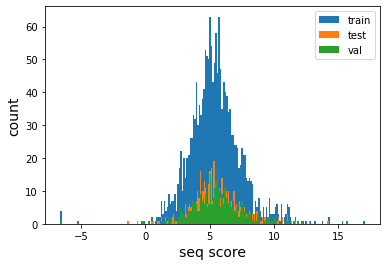

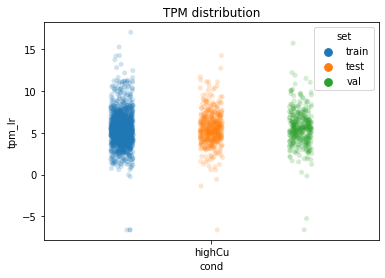

In [55]:
plot_train_test_hist(full_train_df, test_df,score_col='highCu',bins=200,val_df=val_df)
view_train_test_dist(train_df, test_df,["highCu"],"TPM",val_df=val_df)

# split the genes, show dist of logTPM of HighCu column
# plot_train_test_hist(train_df, test_df, val_df=val_df,score_col='log_overall_mean_tpm',bins=200)
# view_train_test_dist(train_df, test_df,["log_overall_mean_tpm"],"TPM",val_df=val_df)

## Load 5G seqs into data loaders

In [56]:
dataset_types = [
    DatasetSpec('ohe'),
#     DatasetSpec('kmer',k=3),
#     DatasetSpec('kmer',k=6),
]

# _RUNNING SHUFFLED SEQS_

In [57]:
# Dfs for the full train/test split
final_dls = tu.build_dataloaders_single(
    full_train_df, 
    test_df, 
    dataset_types,
    #seq_col='upstream_region',
    seq_col='shuffled_seq',
    target_col='highCu'
    #target_col='log_overall_mean_tpm'
)

# Dfs from further spliting train into train and val
dls = tu.build_dataloaders_single(
    train_df, 
    val_df, 
    dataset_types,
    #seq_col='upstream_region',
    seq_col='shuffled_seq',
    target_col='highCu'
    #target_col='log_overall_mean_tpm'
)

# log_kmer6_train_dl,log_kmer6_val_dl = log_dls['kmer_6']
# log_kmer3_train_dl,log_kmer3_val_dl = log_dls['kmer_3']
ohe_train_dl,ohe_val_dl = dls['ohe']

which seq? ['GTCTTCTGAGTGTTATAAGCTGGAGTTCTTCAGTGTTGTGTACCCATAAGGAGATTATTCATATACGCTATATCGGTAGGGCCTATAATGTCACTATTCTGATACGAGTTGATGCGCAAAGCACTACCGCTTTAATTCATCCTGTCTTTTGTATTTCGGTTAAGCGTATTAATAGGGCACTTCCATTCTCGAATTAGTCGGGTCTGTGTTTTAAGAATCAAATGTATGAAGTCTCAGGGTCCTCCAATTCGTATAGAAATTGGACCTGGCGCTGTCCGTGCTTCGACTCTTGACATGCAA', 'TTGATGTGTATATTGGACCTAACTACGCAAACCTTTGTCCTTGTAATGTTAATTTCGGGAGATATTGATCCTATCCACGCGCTTATTGATCTAAACACCACGCGACATCGTTCATTGCTAGATATCCTGAATTAATTCTCCTTAGATAAATATTAAATAAATGATATAACTTTACCCACAAATGTGTATTTGGCTGGAGTTCGGACGAAGGAACCATGATTTTTGAAATTCTGAAAGTTAGCATTAATAGGATTTTGTTAGGTTATGTTGTAGTAAGTTAGATACGACAACTAAAAAAGA', 'ACCATGCTAGACCATTCTCTAAAGCACATCTAGAGGTTACTTGTTAAGTTGGGTGCTTTAACTCAAAAGGGCACTATATGGCGGAAATAGGGTGTGTCATAAATTCAGCTAAAATTTACTTGCCGAGAAAGACTTGGTTTTGCTGAATACCCCTAGCATGCATAAGAACGGTTTGACCTGAAGCCAGCGCGCCTGCTGATGCTTGCAGAAGATAATCAAACCGGGTAGACATCAGCCGTTATGCTATGACCGCGCGATCACCGGAAACAAGAACGTAGTTTACTCTCGAAGCGCCAGCTC', 'ATTTATGAAGATACTACTACGCCAACACGCCTTTTCTGCTCGAATGGATCACGTGAGCGCAGCTGTACACATCAT

which seq? ['GTCTTCTGAGTGTTATAAGCTGGAGTTCTTCAGTGTTGTGTACCCATAAGGAGATTATTCATATACGCTATATCGGTAGGGCCTATAATGTCACTATTCTGATACGAGTTGATGCGCAAAGCACTACCGCTTTAATTCATCCTGTCTTTTGTATTTCGGTTAAGCGTATTAATAGGGCACTTCCATTCTCGAATTAGTCGGGTCTGTGTTTTAAGAATCAAATGTATGAAGTCTCAGGGTCCTCCAATTCGTATAGAAATTGGACCTGGCGCTGTCCGTGCTTCGACTCTTGACATGCAA', 'TTGATGTGTATATTGGACCTAACTACGCAAACCTTTGTCCTTGTAATGTTAATTTCGGGAGATATTGATCCTATCCACGCGCTTATTGATCTAAACACCACGCGACATCGTTCATTGCTAGATATCCTGAATTAATTCTCCTTAGATAAATATTAAATAAATGATATAACTTTACCCACAAATGTGTATTTGGCTGGAGTTCGGACGAAGGAACCATGATTTTTGAAATTCTGAAAGTTAGCATTAATAGGATTTTGTTAGGTTATGTTGTAGTAAGTTAGATACGACAACTAAAAAAGA', 'ACCATGCTAGACCATTCTCTAAAGCACATCTAGAGGTTACTTGTTAAGTTGGGTGCTTTAACTCAAAAGGGCACTATATGGCGGAAATAGGGTGTGTCATAAATTCAGCTAAAATTTACTTGCCGAGAAAGACTTGGTTTTGCTGAATACCCCTAGCATGCATAAGAACGGTTTGACCTGAAGCCAGCGCGCCTGCTGATGCTTGCAGAAGATAATCAAACCGGGTAGACATCAGCCGTTATGCTATGACCGCGCGATCACCGGAAACAAGAACGTAGTTTACTCTCGAAGCGCCAGCTC', 'ATTTATGAAGATACTACTACGCCAACACGCCTTTTCTGCTCGAATGGATCACGTGAGCGCAGCTGTACACATCAT

In [58]:
for xb,yb, in ohe_val_dl:
    print(xb.shape)
    print(yb.shape)
    print()

torch.Size([128, 300, 4])
torch.Size([128, 1])

torch.Size([128, 300, 4])
torch.Size([128, 1])

torch.Size([98, 300, 4])
torch.Size([98, 1])



In [59]:
ohe_val_dl.batch_size

128

## run model 

In [60]:
def collect_model_stats(model_name,seq_len,encoding,
                        train_dl,val_dl,
                        lr=0.001,ep=1000,pat=100,
                        opt=None,model=None,load_best=False):
    
    if not model:
        model = m.DNA_2CNN_2FC_Multi(
            seq_len,
            1, # num tasks
        )
    model.to(DEVICE)

    loss_func = torch.nn.MSELoss() 
    if opt:
        opt = opt(model.parameters(), lr=lr)

    # pass in
    #train_dl,val_dl = dls[encoding] 
    
    train_losses, \
    val_losses, \
    epoch_stop, \
    best_val_score = tu.run_model(
        train_dl,
        val_dl, 
        model, 
        loss_func, 
        DEVICE,
        lr=lr, 
        epochs=ep, 
        opt=opt,
        patience=pat,
        load_best=load_best # comment out to see overfitting in parity plots
    )

    # to plot loss
    data_label = [((train_losses,val_losses),model_name,epoch_stop,best_val_score)]
    tu.quick_loss_plot(data_label)
    
    return {
        'model_name':model_name,
        'model':model,
        'train_losses':train_losses,
        'val_losses':val_losses,
        'epoch_stop':epoch_stop,
        'best_val_score':best_val_score,
        'data_label':data_label
    }

In [61]:
def parity_pred_by_split(model_name,
                         device,
                         locus_col='locus_tag',
                         seq_col='seq',
                         target_col="score",
                         splits=['train','val']
                        ):
    '''
    Given a trained model, get the model's predictions on each split
    of the data and create parity plots of the y predictions vs actual ys
    '''
    # init subplots
    fig, axs = plt.subplots(1,len(splits), sharex=True, sharey=True,figsize=(10,4))
    pred_dfs = {}
    
    def parity_plot(model_title,ytrue,ypred,rigid=True):
        axs[i].scatter(ytrue, ypred, alpha=0.2)

        r2 = r2_score(ytrue,ypred)
        pr = pearsonr(ytrue,ypred)[0]
        sp = spearmanr(ytrue,ypred).correlation

        # y=x line
        xpoints = ypoints = plt.xlim()
        if rigid:
            axs[i].set_ylim(min(xpoints),max(xpoints)) 
        axs[i].plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)
        axs[i].set_title(f"{model_title} (r2:{r2:.2f}|p:{pr:.2f}|sp:{sp:.2f})",fontsize=14)
        axs[i].set_xlabel("Actual Score",fontsize=14)
        axs[i].set_ylabel("Predicted Score",fontsize=14)
    
    for i,split in enumerate(splits):
        print(f"{split} split")
        df = split_dfs[split]
        loci = df[locus_col].values
        seqs = list(df[seq_col].values)        
        ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs]).to(device)
        labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)
    
    #dfs = {} # key: model name, value: parity_df
    
        # initialize prediction df with just locus col
        pred_df = df[[locus_col]]
        pred_df['truth'] = df[target_col]
        print(f"Running {model_name}")
        
        model = model_res[model_name]['model']
        # ask model to predict on seqs
        preds = model(ohe_seqs.float()).tolist()
        # preds is a tensor converted to a list, 
        # single elements returned as a list, hence x[0]
        pred_df['pred'] = [x[0] for x in preds]
        
        # do I want the result dfs? revise if so
        #dfs[model_name] = pred_df
        
        # plot stuff
        ytrue = pred_df['truth'].values
        ypred = pred_df['pred'].values
        
        #plt.subplot(len(splits),i+1,1)
        model_title = split
        parity_plot(model_title,ytrue,ypred)
        
        # save predictions
        pred_dfs[split] = pred_df
    
    
    plt.suptitle(model_name,fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return pred_dfs

In [62]:
model_res = {}
seq_len = len(train_df['upstream_region'].values[0])

E:231 | train loss:2.869 | val loss: 5.480:   5%|▍         | 232/5000 [00:11<04:01, 19.78it/s] 

EarlyStopping counter: 125 out of 500


E:356 | train loss:1.418 | val loss: 6.578:   7%|▋         | 356/5000 [00:18<03:55, 19.71it/s] 

EarlyStopping counter: 250 out of 500


E:481 | train loss:0.857 | val loss: 6.883:  10%|▉         | 482/5000 [00:24<03:51, 19.50it/s] 

EarlyStopping counter: 375 out of 500


E:603 | train loss:0.584 | val loss: 6.719:  12%|█▏        | 603/5000 [00:30<03:44, 19.62it/s]


EarlyStopping counter: 500 out of 500
Early stopping


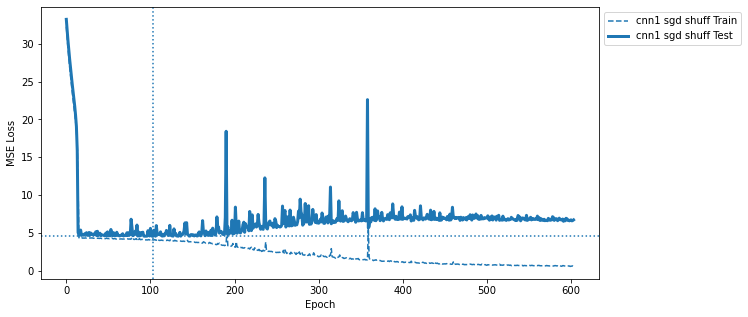

In [63]:
#cnn1_name = 'cnn1 sgd'
cnn1_name = 'cnn1 sgd shuff'
model_res[cnn1_name] = collect_model_stats(
    cnn1_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=500,
)

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn1 sgd shuff
val split
Running cnn1 sgd shuff
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn1 sgd shuff


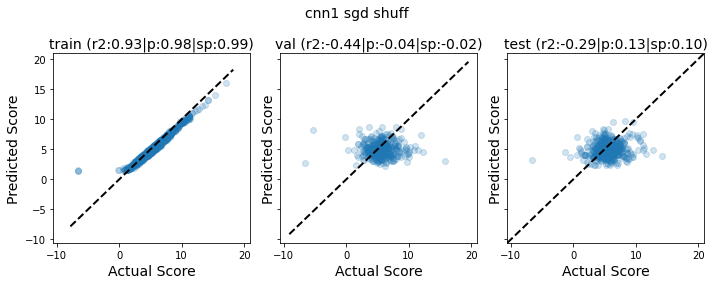

In [64]:
pred_dfs = parity_pred_by_split(cnn1_name,
                     DEVICE,
                     #seq_col='upstream_region',
                     seq_col='shuffled_seq',
                     #target_col='log_overall_mean_tpm',
                     target_col='highCu',
                     splits=['train','val','test']
                    )

E:769 | train loss:0.121 | val loss: 6.672:  15%|█▌        | 770/5000 [00:41<03:44, 18.81it/s]

EarlyStopping counter: 750 out of 3000


E:1519 | train loss:0.087 | val loss: 6.943:  30%|███       | 1520/5000 [01:21<03:05, 18.74it/s]

EarlyStopping counter: 1500 out of 3000


E:2269 | train loss:0.075 | val loss: 6.483:  45%|████▌     | 2270/5000 [02:01<02:24, 18.90it/s]

EarlyStopping counter: 2250 out of 3000


E:3016 | train loss:0.061 | val loss: 6.385:  60%|██████    | 3016/5000 [02:40<01:45, 18.75it/s]


EarlyStopping counter: 3000 out of 3000
Early stopping


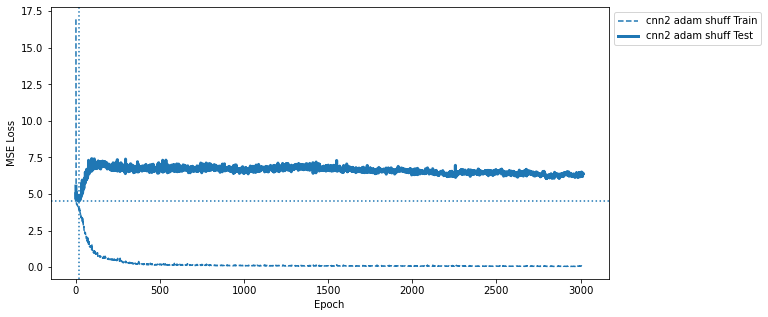

In [65]:
#cnn2_name = 'cnn2 adam'
cnn2_name = 'cnn2 adam shuff'

model_res[cnn2_name] = collect_model_stats(
    cnn2_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=3000,
    opt=torch.optim.Adam
)

train split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Running cnn2 adam shuff
val split
Running cnn2 adam shuff
test split


/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/ubuntu/anaconda3/envs/torchp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Running cnn2 adam shuff


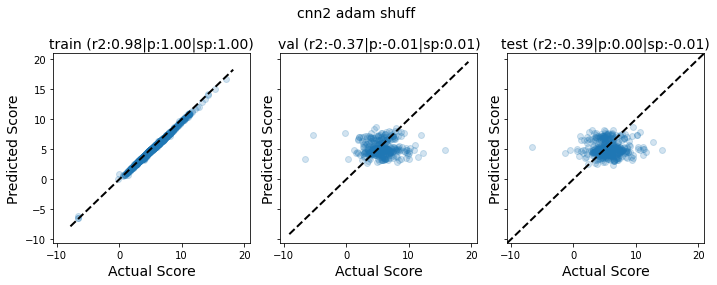

In [66]:
pred_dfs = parity_pred_by_split(cnn2_name,
                                DEVICE,
                                #seq_col='upstream_region',
                                seq_col='shuffled_seq',
                                #target_col='log_overall_mean_tpm',
                                target_col='highCu',
                                splits=['train','val','test']
                    )

In [ ]:
#cnn3_name = 'cnn3 adam slow'
cnn3_name = 'cnn3 adam slow shuff'
model_res[cnn3_name] = collect_model_stats(
    cnn3_name,
    seq_len,
    'ohe',
    ohe_train_dl,
    ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=3000,
    opt=torch.optim.Adam
)

cnn3_pred_dfs = parity_pred_by_split(cnn3_name,
                     DEVICE,
                     seq_col='upstream_region',
                     #seq_col='shuffled_seq',
                     #target_col='log_overall_mean_tpm',
                     target_col='highCu',
                     splits=['train','val','test']
                    )

E:833 | train loss:0.660 | val loss: 5.058:  17%|█▋        | 834/5000 [00:44<03:44, 18.57it/s]

EarlyStopping counter: 750 out of 3000


E:1129 | train loss:0.496 | val loss: 4.863:  23%|██▎       | 1130/5000 [01:00<03:27, 18.66it/s]

In [ ]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

### ok so overfitting is happening... move away from this with data aug

# Data Augmentation

In [ ]:
def augment_mutate(df,n,seq_col='upstream_region',mutation_rate=0.1):
    '''
    Given a dataframe of training data, augment it by adding 
    mutated versions back into the data frame
    '''
    mutation_dict = {
        'A':['C','G','T'],
        'C':['G','T','A'],
        'G':['T','A','C'],
        'T':['A','C','G'],
        'N':['N'] # no signal, just ignore
    }
    new_rows = []
    # for each row in the original df
    for i,row in df.iterrows():
        seq = row[seq_col]
                
        # generate n mutants
        for j in range(n):
            new_row = copy.deepcopy(row)
            new_seq = list(seq)
            mutate_vec = [random.random() for x in range(len(seq))]
            
            # loop through mutation values along length of the seq
            for k in range(len(seq)):
                # if random value is below mutation rate, then make a change
                if mutate_vec[k] < mutation_rate:
                    cur_base = seq[k]
                    # select new base randomly
                    new_base = random.choice(mutation_dict[cur_base])
                    new_seq[k] = new_base
            
            new_row[seq_col] = ''.join(new_seq)
            new_row['seq_version'] = j+1
            new_rows.append(new_row.values)

    # put new rows into a df
    new_rows = pd.DataFrame(new_rows,columns=new_row.index)
    # add version to og df 
    df['seq_version'] = 0
    
    return pd.concat([df,new_rows])



In [ ]:
n=10
#aug_train_df = augment_mutate(train_df,n,seq_col='upstream_region')
aug_train_df = augment_mutate(train_df,n,seq_col='shuffled_seq')

In [ ]:
aug_train_df

In [ ]:
plot_train_test_hist(aug_train_df, test_df,score_col='highCu',bins=200,val_df=val_df)
view_train_test_dist(aug_train_df, test_df,["highCu"],"TPM",val_df=val_df)

In [ ]:
# Dfs from further spliting train into train and val
aug_dls = tu.build_dataloaders_single(
    aug_train_df, 
    val_df, 
    dataset_types,
    #seq_col='upstream_region',
    seq_col='shuffled_seq',
    target_col='highCu'
)

# log_kmer6_train_dl,log_kmer6_val_dl = log_dls['kmer_6']
# log_kmer3_train_dl,log_kmer3_val_dl = log_dls['kmer_3']
aug_ohe_train_dl,aug_ohe_val_dl = aug_dls['ohe']

In [ ]:
#cnn4_name = 'cnn4 adam slow aug'
cnn4_name = 'cnn4 adam slow aug shuff'
model_res[cnn4_name] = collect_model_stats(
    cnn4_name,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    aug_ohe_val_dl,
    lr=0.0001,
    ep=5000,
    pat=1000,
    opt=torch.optim.Adam
)

pred_dfs = parity_pred_by_split(cnn4_name,
                     DEVICE,
                     #seq_col='upstream_region',
                     seq_col='shuffled_seq',
                     #target_col='log_overall_mean_tpm',
                     target_col='highCu',
                     splits=['train','val','test']
                    )

In [ ]:
cnn5_name = 'cnn5 adam aug shuff'
model_res[cnn5_name] = collect_model_stats(
    cnn5_name,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    aug_ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=1000,
    opt=torch.optim.Adam
)

cnn5_pred_df = parity_pred_by_split(cnn5_name,
                     DEVICE,
                     #seq_col='upstream_region',
                     seq_col='shuffled_seq',
                     #target_col='log_overall_mean_tpm',
                     target_col='highCu',
                     splits=['train','val','test']
                    )

In [ ]:
# tu.quick_loss_plot(
#     model_res[cnn1_name]['data_label']+\
#     model_res[cnn2_name]['data_label']+\
#     model_res[cnn3_name]['data_label']+\
#     model_res[cnn4_name]['data_label']+\
#     model_res[cnn5_name]['data_label'])

tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

In [ ]:
line = pd.DataFrame({
    'truth': [-5, 15],
    'pred':  [-5, 15],
})

line_plot = alt.Chart(line).mark_line(color= 'black').encode(
    x= 'truth',
    y= 'pred',
)

v = cnn5_pred_df['val']
v['gene'] = v['locus_tag'].apply(lambda x: locus2info[x]['gene'])
v['product'] = v['locus_tag'].apply(lambda x: locus2info[x]['product'])
v['type'] = v['locus_tag'].apply(lambda x: locus2info[x]['type'])

chart = alt.Chart(v).mark_circle(size=60).encode(
    x='truth:Q',
    y='pred:Q',
    color='type:N',
    tooltip=['locus_tag:N','gene:N','product:N']
).interactive()

chart + line_plot

In [ ]:
t = cnn5_pred_df['test']
t['gene'] = t['locus_tag'].apply(lambda x: locus2info[x]['gene'])
t['product'] = t['locus_tag'].apply(lambda x: locus2info[x]['product'])
t['type'] = t['locus_tag'].apply(lambda x: locus2info[x]['type'])

chart = alt.Chart(t).mark_circle(size=60).encode(
    x='truth:Q',
    y='pred:Q',
    color='type:N',
    tooltip=['locus_tag:N','gene:N','product:N']
).interactive()

chart + line_plot

## smaller models?

In [ ]:
name = 'cnn6 adam filt 8 fc 10,1'
model = m.DNA_2CNN_2FC_Multi(
    seq_len,
    1, # num tasks
    num_filters1=8,
    num_filters2=8,
    conv_pool_size1=3,
    fc_node_num1=10,
    fc_node_num2=1
)

model_res[name] = collect_model_stats(
    name,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=1000,
    opt=torch.optim.Adam,
    model=model
)

pred_dfs = parity_pred_by_split(name,
                     DEVICE,
                     seq_col='upstream_region',
                     target_col='highCu',
                     splits=['train','val','test']
                    )

In [ ]:
name = 'cnn7 adam filt 32,16 fc5'
model = m.DNA_2CNN_2FC_Multi(
    seq_len,
    1, # num tasks
    num_filters1=32,
    num_filters2=16,
    conv_pool_size1=2,
    fc_node_num1=5,
    fc_node_num2=5
)

model_res[name] = collect_model_stats(
    name,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=1000,
    opt=torch.optim.Adam,
    model=model
)

pred_dfs = parity_pred_by_split(name,
                     DEVICE,
                     seq_col='upstream_region',
                     target_col='highCu',
                     splits=['train','val','test']
                    )

In [ ]:
tu.quick_loss_plot([model_res[x]['data_label'][0] for x in model_res])

In [ ]:
name = 'cnn8 adam filt 16 droppier'
model = m.DNA_2CNN_2FC_Multi(
    seq_len,
    1, # num tasks
    num_filters1=16,
    num_filters2=16,
    conv_pool_size1=3,
    dropout1=0.4,
    dropout2=0.4,
    
)

model_res[name] = collect_model_stats(
    name,
    seq_len,
    'ohe',
    aug_ohe_train_dl,
    ohe_val_dl,
    lr=0.001,
    ep=5000,
    pat=1000,
    opt=torch.optim.Adam,
    model=model
)

parity_pred_by_split(name,
                     DEVICE,
                     seq_col='upstream_region',
                     target_col='highCu',
                     splits=['train','val','test']
                    )

In [ ]:
# THIs should be wrong... what does it look like?
pred_dfs = parity_pred_by_split(name,
                     DEVICE,
                     seq_col='upstream_region',
                     target_col='log_overall_mean_tpm',
                     splits=['train','val','test']
                    )

# NOW, let's do this again with shuffled seqs